In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scipy.integrate as integrate
import scipy

## 1D периодический потенциал

In [3]:
def fourier_coeff(f, a, U_0, n):
    if (n == 0):
        return integrate.quad(lambda x: f(x, a, U_0) / a, 0, a)[0]
    else:
        A = integrate.quad(lambda x: (2/a) * f(x, a, U_0) * np.cos(n * 2 * np.pi * x / a), 0, a)[0]
        B = integrate.quad(lambda x: (2/a) * f(x, a, U_0) * np.sin(n * 2 * np.pi * x / a), 0, a)[0]
        return (A - 1j * B)/2
    

def fourier_pol(x, c, a):
    N = (len(c) - 1) // 2
    P = 0
    for i in range(2 * N + 1):
        P += c[i] * np.exp(1j * 2 * np.pi * x * (i - N) / a)
    return np.real(P)

In [32]:
def U(x, T, U_0=1):
    t = x - T * (x // T)
    return -U_0 * np.exp(-(5000/T**2)*(t-T/4)**2)

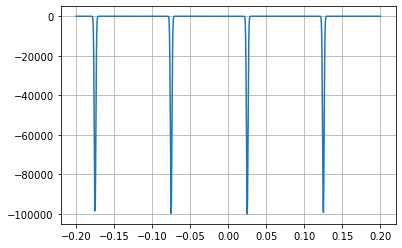

In [36]:
a = 0.1
U_0 = 100000
N = 1000
x = np.linspace(-2*a,2*a,N)

plt.grid(True)
plt.plot(x, U(x, a, U_0))

In [37]:
potential = U

n_max = 40

c_tilde = []
for i in range(2 * n_max + 1):
    c_tilde.append(fourier_coeff(potential, a, U_0, i - n_max))

A = np.zeros((2 * n_max + 1, 2 * n_max + 1), dtype=complex)
for i in range(2 * n_max + 1):
    for j in range(2 * n_max + 1):
        if (j <= i):
            A[i,j] = np.conjugate(c_tilde[j - i + n_max])
        else:
            A[i,j] = c_tilde[i - j + n_max]    

def energy_levels(k, n_max):
    dimension = 2 * n_max + 1
    D = np.zeros((dimension, dimension), dtype=complex)
    for i in range(dimension):
        D[i,i] = k**2 + (4 * np.pi**2 * (i - n_max - 1)**2) / a**2 + (4 * np.pi * k * (i - n_max - 1)) / a
    H = A + D
    E, _ = np.linalg.eig(H)
    E = np.real(E)
    return sorted(E)

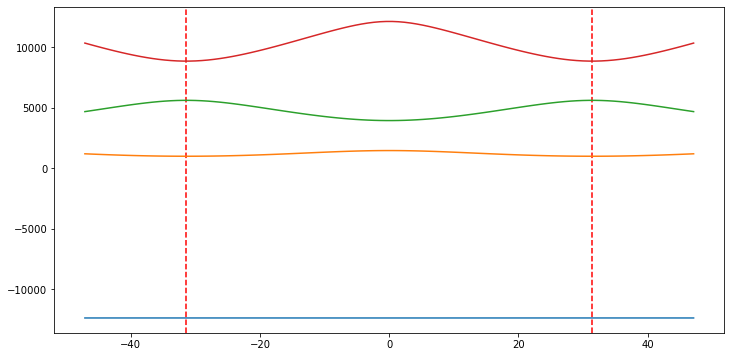

In [38]:
b_zone = np.linspace(-1.5 * np.pi / a, 1.5 * np.pi / a, 100)
num_branches = 4
branches = [[] for i in range(num_branches)]
for k in b_zone:
    levels = energy_levels(k, n_max)
    for i in range(num_branches):
        branches[i].append(levels[i])
        
plt.figure(figsize=(12,6))
plt.axvline(-np.pi / a, color='r', linestyle='--')
plt.axvline(np.pi / a, color='r', linestyle='--')
for br in branches:
    plt.plot(b_zone, br)

## 2D периодический потенциал

In [10]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm

In [11]:
def U_2D(x, y, ax, ay, U_0):
    tx, ty = x - ax * (x // ax), y - ay * (y // ay)
    C = 6000
    p1 = np.exp(-C * (tx**2 + ty**2))
    p2 = np.exp(-C * ((tx-ax)**2 + (ty-ay)**2))
    p3 = np.exp(-C * ((tx)**2 + (ty-ay)**2))
    p4 = np.exp(-C * ((tx-ax)**2 + (ty)**2))
    p5 = np.exp(-C * ((tx-ax/2)**2 + (ty-ay/2)**2))
    return -U_0 * (p1+p2+p3+p4+p5)

In [12]:
def fourier_coeff2D(f, ax, ay, U_0, m, n):
    if (m == 0 and n == 0):
        return integrate.dblquad(lambda x, y: f(x, y, ax, ay, U_0) / (ax*ay), 0,ax, 0,ay)[0]
    else:
        A = integrate.dblquad(lambda x, y: (1/(ax*ay))*f(x,y,ax,ay,U_0)*np.cos(2*np.pi*(m*x/ax + n*y/ay)),0,ax,0,ay)[0]
        B = integrate.dblquad(lambda x, y: (1/(ax*ay))*f(x,y,ax,ay,U_0)*np.sin(2*np.pi*(m*x/ax + n*y/ay)),0,ax,0,ay)[0]
        return A - 1j * B

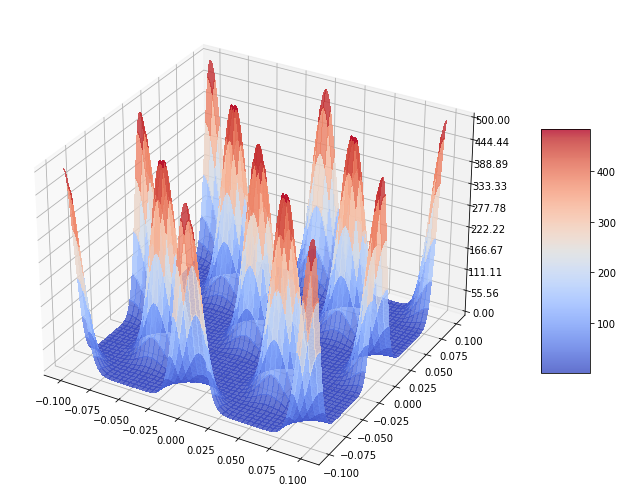

In [13]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection='3d')

a_x, a_y = 0.1, 0.1
U_0 = 500
N = 700
X = np.linspace(-a_x, a_x, N)
Y = np.linspace(-a_y, a_y, N)
Z = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Z[i,j] = -U_2D(X[i], Y[j], a_x, a_y, U_0)
X, Y = np.meshgrid(X, Y)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, alpha=.8, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
potential = U_2D

n_max = 15
dimension = 2 * n_max + 1

c_tilde = np.zeros((dimension, dimension), dtype=complex)
for i in tqdm(range(dimension)):
    for j in range(dimension):
        c_tilde[i,j] = fourier_coeff2D(potential, a_x, a_y, U_0, i-n_max, j-n_max)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [08:45<00:00, 16.96s/it]


In [15]:
def D(kx, ky):
    M = np.zeros((dimension,dimension))
    for i in range(dimension):
        for j in range(dimension):
            M[i,j] = kx**2 + ky**2 + 4 * np.pi**2 * ((i - n_max - 1)**2 / a_x**2 + (j - n_max - 1)**2 / a_y**2) + 4 * np.pi * (kx * (i - n_max - 1) / a_x + ky * (j - n_max - 1) / a_y)
    return M

In [19]:
def energy_levels_2D(kx, ky, n_max):
    dimension = 2 * n_max + 1
    D_reshaped = np.reshape(D(kx, ky), (dimension**2))
    D_2D = np.zeros((dimension**2, dimension**2))
    for i in range(dimension**2):
        D_2D[i,i] = D_reshaped[i]
    H_2D = A_2D + D_2D
    E, _ = np.linalg.eig(H_2D)
    E = sorted(np.real(E))
    return E

In [16]:
# reshape
c_tilde_reshaped = np.reshape(c_tilde, (dimension**2))
A_2D = np.zeros((dimension**2, dimension**2), dtype=complex)
for i in range(dimension**2):
    for j in range(dimension**2):
        if (j <= i):
            A_2D[i,j] = np.conjugate(c_tilde_reshaped[j - i + (dimension**2 - 1)//2])
        else:
            A_2D[i,j] = c_tilde_reshaped[i - j + (dimension**2 - 1)//2]    

In [20]:
hk = 15
num_branches = 3
KX = np.linspace(-1.2 * np.pi / a_x, 1.2 * np.pi / a_x, hk)
KY = np.linspace(-1.2 * np.pi / a_y, 1.2 * np.pi / a_y, hk)
EK_branches = [np.zeros((hk,hk)) for i in range(num_branches)]
for i in tqdm(range(hk)):
    for j in range(hk):
        EL = energy_levels_2D(KX[i], KY[j], n_max)
        for p in range(num_branches):
            EK_branches[p][i,j] = EL[p]
KX, KY = np.meshgrid(KX, KY)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [14:33<00:00, 58.25s/it]


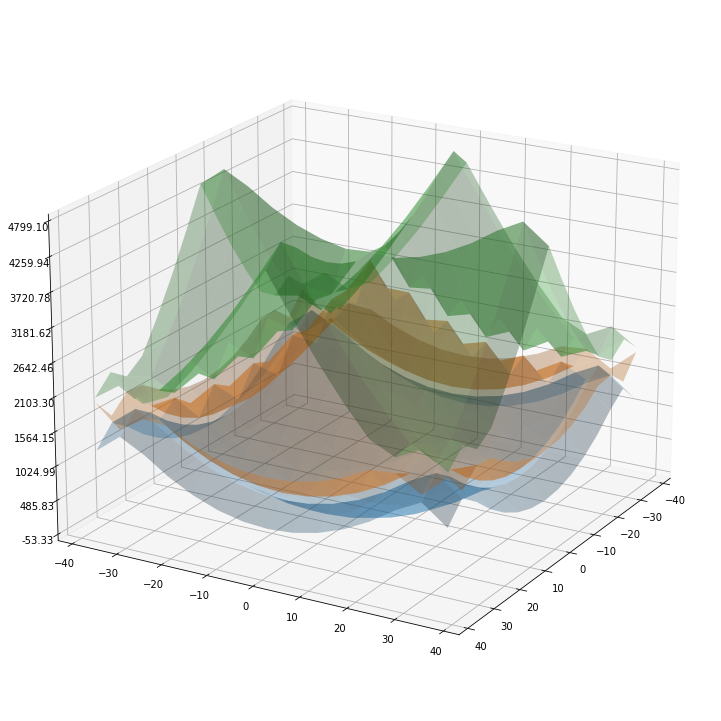

In [40]:
fig = plt.figure(figsize=(25,13))
ax = fig.add_subplot(projection='3d')

for b in EK_branches:
    surf = ax.plot_surface(KX, KY, b, alpha=.3)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

ax.view_init(elev=20, azim=30)